Num GPUs Available:  0
dict_keys(['Original', 'ADASYN', 'ClusterBased', 'NearMiss', 'SMOTE', 'Original_balanced'])
Final class weights dictionary:
{'Original': None, 'ADASYN': None, 'ClusterBased': None, 'NearMiss': None, 'SMOTE': None, 'Original_balanced': {0: 0.6428571428571429, 1: 2.25}}
Class weight for the Original is :None
Restoring model weights from the end of the best epoch: 100.
Epoch 83: early stopping
Restoring model weights from the end of the best epoch: 58.
Class weight for the ADASYN is :None
Epoch 75: early stopping
Restoring model weights from the end of the best epoch: 50.
Epoch 57: early stopping
Restoring model weights from the end of the best epoch: 32.
Class weight for the ClusterBased is :None
Epoch 28: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 27: early stopping
Restoring model weights from the end of the best epoch: 2.
Class weight for the NearMiss is :None
Epoch 93: early stopping
Restoring model weights from the end of t

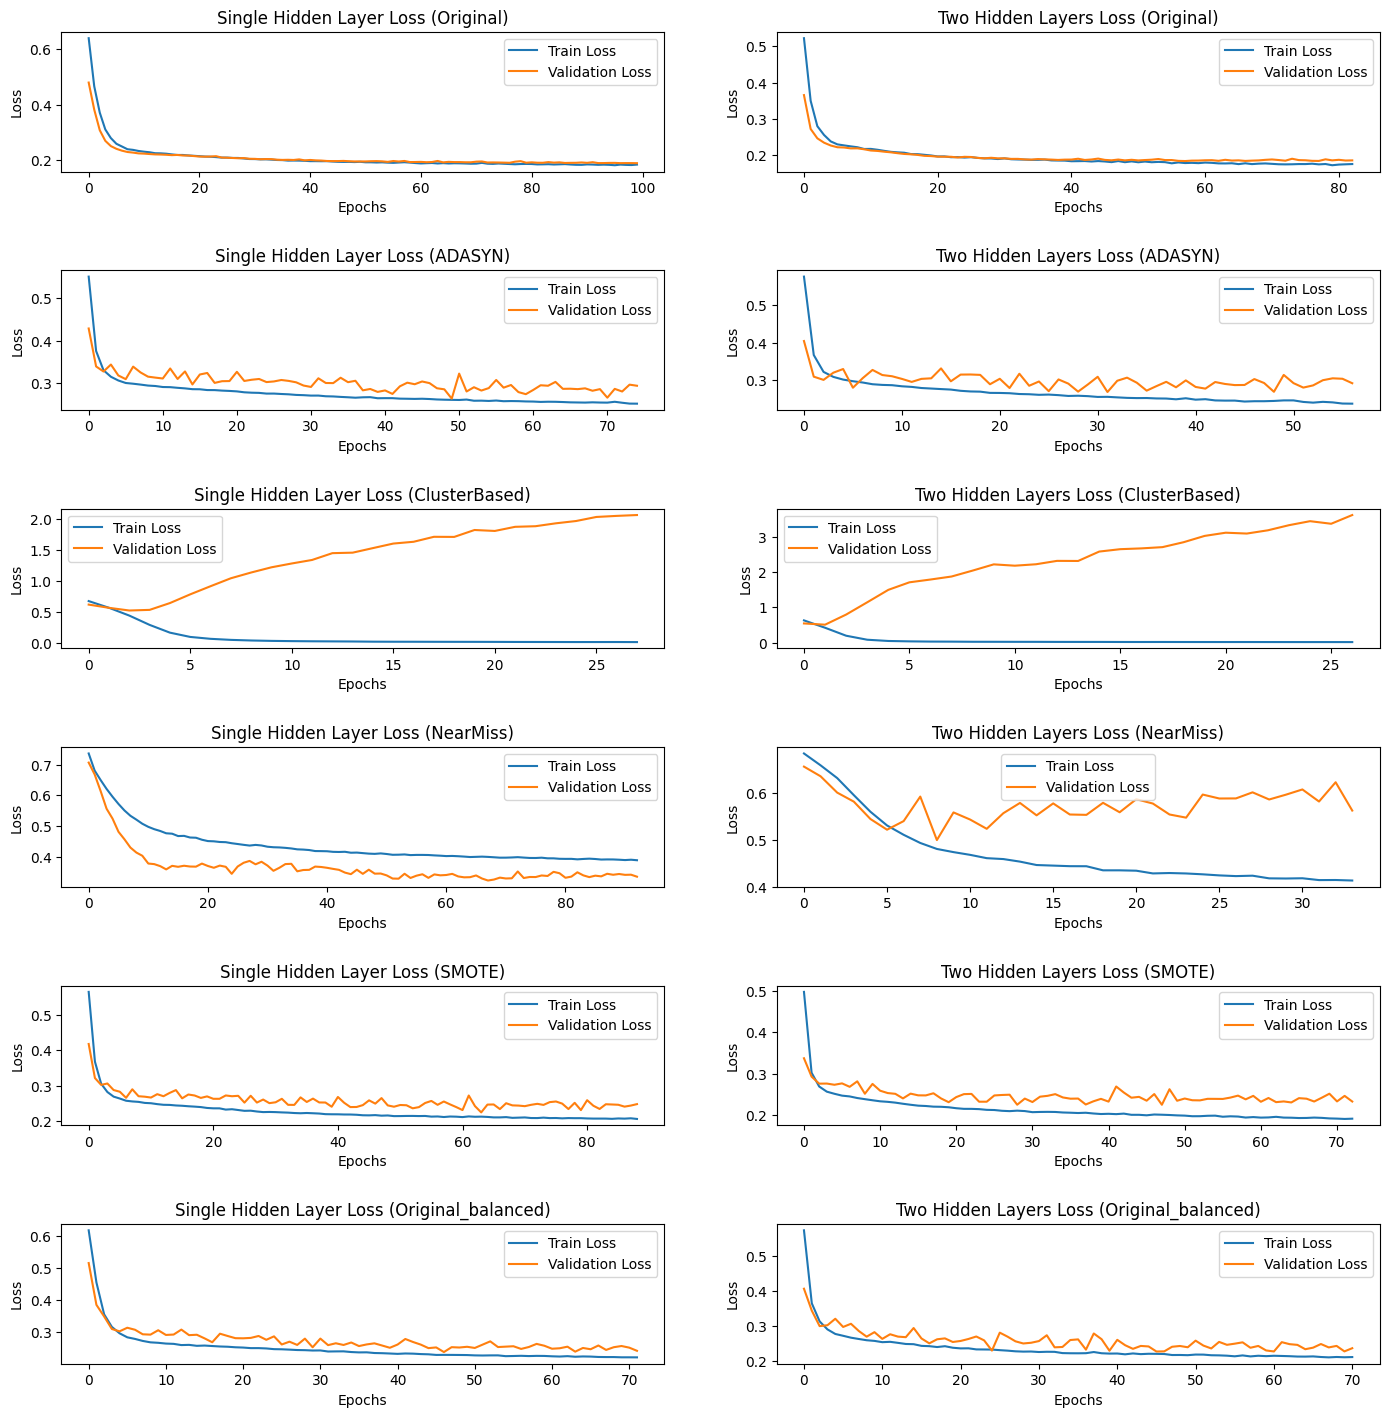

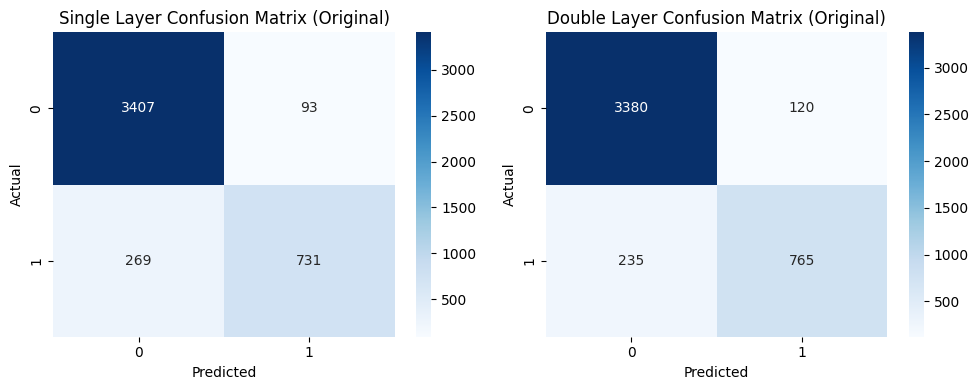

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for one hidden layer model (ADASYN):
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      3500
           1       0.63      0.94      0.76      1000

    accuracy                           0.87      4500
   macro avg       0.81      0.89      0.83      4500
weighted avg       0.90      0.87      0.87      4500

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for two hidden layers model (ADASYN):
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      3500
           1       0.63      0.94      0.75      1000

    accuracy                           0.86      4500
   macro avg       0.80      0.89      0.83      4500
weighted avg       0.90      0.86      0.87      4500



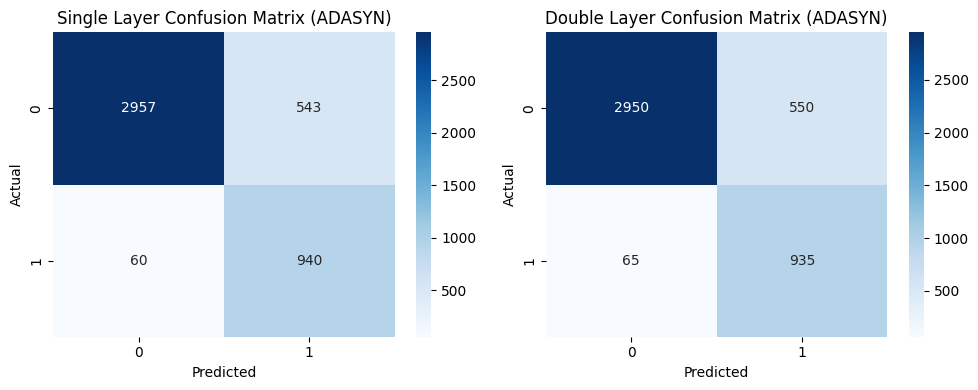

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for one hidden layer model (ClusterBased):
              precision    recall  f1-score   support

           0       0.99      0.72      0.83      3500
           1       0.49      0.97      0.65      1000

    accuracy                           0.77      4500
   macro avg       0.74      0.84      0.74      4500
weighted avg       0.88      0.77      0.79      4500

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for two hidden layers model (ClusterBased):
              precision    recall  f1-score   support

           0       1.00      0.68      0.81      3500
           1       0.47      0.99      0.64      1000

    accuracy                           0.75      4500
   macro avg       0.73      0.84      0.72      4500
weighted avg       0.88      0.75      0.77      4500



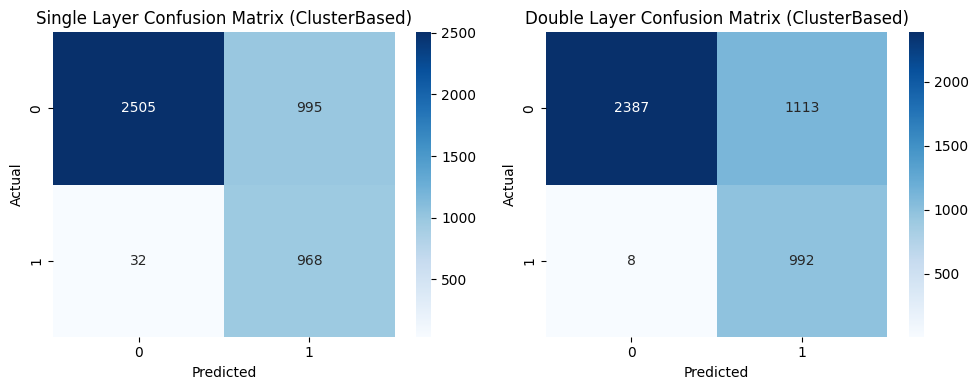

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for one hidden layer model (NearMiss):
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3500
           1       0.78      0.75      0.76      1000

    accuracy                           0.90      4500
   macro avg       0.85      0.84      0.85      4500
weighted avg       0.89      0.90      0.89      4500

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for two hidden layers model (NearMiss):
              precision    recall  f1-score   support

           0       0.90      0.80      0.85      3500
           1       0.50      0.70      0.58      1000

    accuracy                           0.78      4500
   macro avg       0.70      0.75      0.72      4500
weighted avg       0.81      0.78      0.79      4500



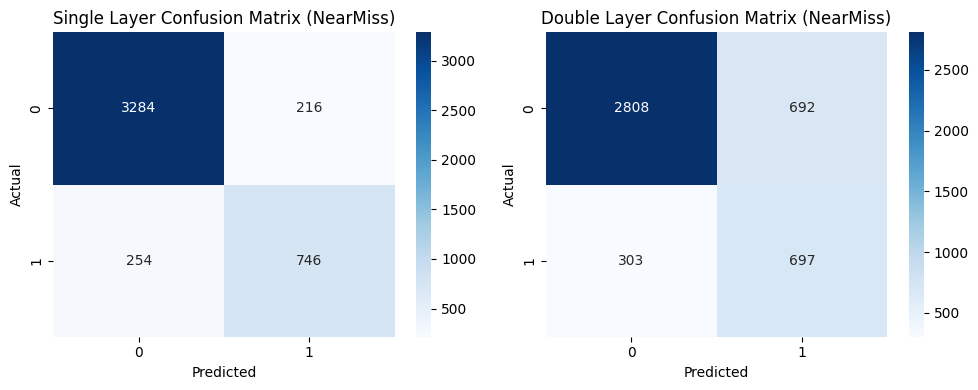

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for one hidden layer model (SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3500
           1       0.70      0.90      0.79      1000

    accuracy                           0.89      4500
   macro avg       0.83      0.90      0.86      4500
weighted avg       0.91      0.89      0.90      4500

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for two hidden layers model (SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3500
           1       0.71      0.90      0.79      1000

    accuracy                           0.89      4500
   macro avg       0.84      0.90      0.86      4500
weighted avg       0.91      0.89      0.90      4500



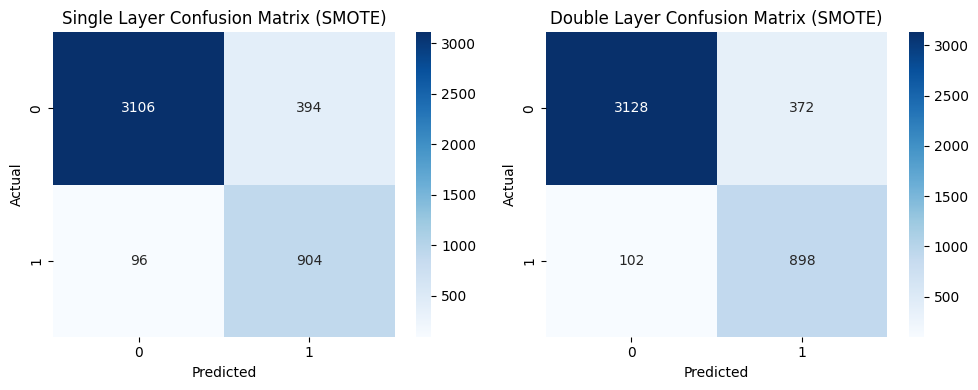

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for one hidden layer model (Original_balanced):
              precision    recall  f1-score   support

           0       0.97      0.88      0.92      3500
           1       0.68      0.92      0.78      1000

    accuracy                           0.89      4500
   macro avg       0.83      0.90      0.85      4500
weighted avg       0.91      0.89      0.89      4500

141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Classification report for two hidden layers model (Original_balanced):
              precision    recall  f1-score   support

           0       0.97      0.89      0.93      3500
           1       0.70      0.91      0.79      1000

    accuracy                           0.89      4500
   macro avg       0.84      0.90      0.86      4500
weighted avg       0.91      0.89      0.90      4500



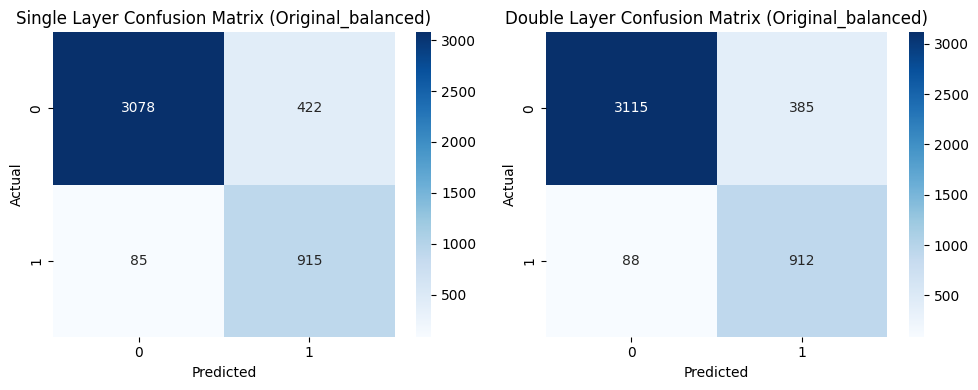

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from google.colab import files
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check if any GPU is available to use
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Upload files (needed since trained the model using google collab)
#uploaded = files.upload()
# Load datasets and drop the 'ID' column
training_sets = {
    "Original": pd.read_csv('training_data_ID_numeric.csv').drop(columns=['ID']),
    "ADASYN": pd.read_csv('training_data_ID_numeric_adasyn.csv').drop(columns=['ID']),
    "ClusterBased": pd.read_csv('training_data_ID_numeric_clusterbased.csv').drop(columns=['ID']),
    "NearMiss": pd.read_csv('training_data_ID_numeric_nearmiss.csv').drop(columns=['ID']),
    "SMOTE": pd.read_csv('training_data_ID_numeric_smote.csv').drop(columns=['ID'])
}

validation_set = pd.read_csv('validation_data_ID_numeric.csv').drop(columns=['ID'])
test_set = pd.read_csv('test_data_ID_numeric.csv').drop(columns=['ID'])

# Separate features (X) and target (y) from validation and test sets
X_val = validation_set.drop(columns=['loan_status']).values
y_val = validation_set['loan_status'].values

X_test = test_set.drop(columns=['loan_status']).values
y_test = test_set['loan_status'].values

# Convert target (y) to categorical
num_classes = len(np.unique(y_val))
y_val = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)


# Train a model for each training set (single and double hidden layer models)
checkpoint_filepath_single = 'best_model_single.keras'
checkpoint_filepath_double = 'best_model_double.keras'


#check class imbalance if there is any imbalance which exceeds the threshhold value in any of the training set return imbalance_ratio
def is_imbalanced(y):
    counter = Counter(y)
    ratios = [count / sum(counter.values()) for count in counter.values()]
    imbalance_ratio = max(ratios) / min(ratios)
    return imbalance_ratio > 1.5  # Threshold for imbalance

# Create class weight dict for each training set where they initially none
class_weights_dict = {key: None for key in training_sets.keys()}

for name, training_set in list(training_sets.items()):
    X_train = training_set.drop(columns=['loan_status']).values
    y_train = training_set['loan_status'].values

    # Handle class imbalance if encountered with any class imbalance
    if is_imbalanced(y_train):
        # Compute class weights
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train.flatten()),
            y=y_train.flatten()
        )
        class_weights = dict(enumerate(class_weights))

        # Create a new balanced training set
        balanced_name = f"{name}_balanced"
        balanced_training_set = training_set.copy()  # Copy the original dataset

        # Add the balanced training set to the dictionary
        training_sets[balanced_name] = balanced_training_set

        # Add class weight only for balanced training set
        class_weights_dict[balanced_name] = class_weights
    else:
        # Don't change the class weights of the other training sets
        class_weights_dict[name] = None

# Final class weights dictionary kontrol
print(training_sets.keys())
print("Final class weights dictionary:")
print(class_weights_dict)


# Plot settings
fig, axes = plt.subplots(len(training_sets), 2, figsize=(15, 15))
fig.tight_layout(pad=5.0)


for i, (name, training_set) in enumerate(training_sets.items()):
    X_train = training_set.drop(columns=['loan_status']).values
    y_train = training_set['loan_status'].values

    # Convert training target to categorical
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Define early stopping callbacks
    #If there is no improvement on validation loss value for 15 epochs then stop the model training
    early_stopping_single = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    )

    early_stopping_double = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=25,
        restore_best_weights=True,
        verbose=1
    )

    # Single hidden layer model
    single_layer_model = Sequential()
    single_layer_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))  #Input layer
    single_layer_model.add(Dense(32, activation='relu'))  # Single hidden layer
    single_layer_model.add(Dropout(0.5))
    single_layer_model.add(Dense(num_classes, activation='softmax')) #Output layer

    single_layer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    #Checkpoint for single hidden layered ANN model, store the parameters where program performs best according to validation loss
    checkpoint_callback_single = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"best_model_single_{name}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )
    print(f"Class weight for the {name} is :{class_weights_dict[name]}")
    single_history = single_layer_model.fit(X_train, y_train,
                                            epochs=100,
                                            batch_size=1024,
                                            validation_data=(X_val, y_val),
                                            class_weight=class_weights_dict[name],
                                            callbacks=[checkpoint_callback_single, early_stopping_single],
                                            verbose=0)  # Suppress output

    # Two hidden layer model
    double_layer_model = Sequential()
    double_layer_model.add(Dense(128, input_dim=X_train.shape[1], activation='relu')) #Input layer
    double_layer_model.add(Dense(64, activation='relu')) # Add first hidden layer
    double_layer_model.add(Dropout(0.5))
    double_layer_model.add(Dense(32, activation='relu'))  # Add second hidden layer
    double_layer_model.add(Dropout(0.5))
    double_layer_model.add(Dense(num_classes, activation='softmax')) #Output layer

    double_layer_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                                loss='categorical_crossentropy',
                                metrics=['accuracy'])

    #Checkpoint for double hidden layered ANN model, store the parameters where program performs best according to validation loss
    checkpoint_callback_double = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"best_model_double_{name}.keras",
        monitor='val_loss',
        save_best_only=True,
        mode='min',
        verbose=0
    )

    double_history = double_layer_model.fit(X_train, y_train,
                                            epochs=100,
                                            batch_size=1024,
                                            validation_data=(X_val, y_val),
                                            class_weight=class_weights_dict[name],
                                            callbacks=[checkpoint_callback_double, early_stopping_double],
                                            verbose=0)  # Do not print out anything

    # Plot training and validation loss for single layer model
    axes[i, 0].plot(single_history.history['loss'], label='Train Loss')
    axes[i, 0].plot(single_history.history['val_loss'], label='Validation Loss')
    axes[i, 0].set_title(f'Single Hidden Layer Loss ({name})')
    axes[i, 0].set_xlabel('Epochs')
    axes[i, 0].set_ylabel('Loss')
    axes[i, 0].legend()

    # Plot training and validation loss for double layer model
    axes[i, 1].plot(double_history.history['loss'], label='Train Loss')
    axes[i, 1].plot(double_history.history['val_loss'], label='Validation Loss')
    axes[i, 1].set_title(f'Two Hidden Layers Loss ({name})')
    axes[i, 1].set_xlabel('Epochs')
    axes[i, 1].set_ylabel('Loss')
    axes[i, 1].legend()

# Evaluate models with the help of test data
for name, training_set in training_sets.items():
    X_train = training_set.drop(columns=['loan_status']).values
    y_train = training_set['loan_status'].values

    # Convert training target to categorical
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Reload best model for single layer
    single_layer_model.load_weights(f"best_model_single_{name}.keras")
    y_pred_single = single_layer_model.predict(X_test)
    y_pred_labels_single = np.argmax(y_pred_single, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    single_corrects = np.sum(y_pred_labels_single == y_test_labels)
    single_accuracy = single_corrects / len(y_test_labels)
    single_f1 = f1_score(y_test_labels, y_pred_labels_single, average='weighted')
    #print(f"Test accuracy for single hidden layer model ({name}): {single_accuracy:.2f}")
    #print(f"F1-score for single hidden layer model ({name}): {single_f1:.2f}")

    single_conf_matrix = confusion_matrix(y_test_labels, y_pred_labels_single)
    print(f"Classification report for one hidden layer model ({name}):")
    print(classification_report(y_test_labels, y_pred_labels_single))
    # Reload best model for double layer
    double_layer_model.load_weights(f"best_model_double_{name}.keras")
    y_pred_double = double_layer_model.predict(X_test)
    y_pred_labels_double = np.argmax(y_pred_double, axis=1)

    double_corrects = np.sum(y_pred_labels_double == y_test_labels)
    double_accuracy = double_corrects / len(y_test_labels)
    double_f1 = f1_score(y_test_labels, y_pred_labels_double, average='weighted')
    #print(f"Test accuracy for two hidden layers model ({name}): {double_accuracy:.2f}")
    #print(f"F1-score for two hidden layers model ({name}): {double_f1:.2f}")
    double_conf_matrix = confusion_matrix(y_test_labels, y_pred_labels_double)

    print(f"Classification report for two hidden layers model ({name}):")
    print(classification_report(y_test_labels, y_pred_labels_double))

    confusion_matrices = []
    confusion_matrices.append(single_conf_matrix)
    confusion_matrices.append(double_conf_matrix)

    # Plot confusion matrices for single and double layer models
    fig_cm, axes_cm = plt.subplots(1, 2, figsize=(10,4))

    sns.heatmap(single_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes_cm[0])
    axes_cm[0].set_title(f'Single Layer Confusion Matrix ({name})')
    axes_cm[0].set_xlabel('Predicted')
    axes_cm[0].set_ylabel('Actual')

    sns.heatmap(double_conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes_cm[1])
    axes_cm[1].set_title(f'Double Layer Confusion Matrix ({name})')
    axes_cm[1].set_xlabel('Predicted')
    axes_cm[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()
    plt.close(fig_cm)

plt.show()
